# Курсовой проект

## Тема “Обучение с учителем”

## Задание

<i>Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv.<br>
Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).</i>

In [4425]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib 
import random
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
import seaborn as sns
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

matplotlib.rcParams.update({'font.size': 9})


In [4426]:
# Оценка качества
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print(f'Train R2: {round(r2_score(train_true_values, train_pred_values), 3)},\
            Test R2:{round(r2_score(test_true_values, test_pred_values), 3)}')
    
    check_train = pd.DataFrame({
        "true": train_true_values,
        "pred": train_pred_values.flatten(),
    })

    check_test = pd.DataFrame({
        "true": test_true_values,
        "pred": test_pred_values.flatten(),
    })

    sns.scatterplot(data=check_train, x="pred", y="true", alpha=.5, label="Train")
    sns.scatterplot(data=check_test, x="pred", y="true", alpha=.5, label="Test")

In [4427]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### 1.Импорт датасета:<br><br>
<b><i>Описание датасета:</i></b><br>
<b>Id</b> - идентификационный номер квартиры<br>
<b>DistrictId</b> - идентификационный номер района (категориальный признак)<br>
<b>Rooms</b> - количество комнат (вещественный признак)<br>
<b>Square</b> - площадь (вещественный признак)<br>
<b>LifeSquare</b> - жилая площадь (вещественный признак)<br>
<b>KitchenSquare</b> - площадь кухни (вещественный признак)<br>
<b>Floor</b> - этаж<br>
<b>HouseFloor</b> - количество этажей в доме<br>
<b>HouseYear</b> - год постройки дома<br>
<b>Ecology_1, Ecology_2, Ecology_3</b> - экологические показатели местности<br>
<b>Social_1, Social_2, Social_3</b> - социальные показатели местности<br>
<b>Healthcare_1, Helthcare_2</b> - показатели местности, связанные с охраной здоровья<br>
<b>Shops_1, Shops_2</b> - показатели, связанные с наличием магазинов, торговых центров<br>
<b>Price (целевой вещественный признак)</b> - цена квартиры

In [4428]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [4429]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [4430]:
test_df = pd.read_csv("test.csv")
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [4431]:
print(f'Строк на трейне: {train_df.shape[0]}, Строк на тесте: {test_df.shape[0]}')

Строк на трейне: 10000, Строк на тесте: 5000


In [4432]:
# Проверим соответсвие признаков на тесте и на обучении - 1 целевой признак
train_df.shape[1] - 1 == test_df.shape[1]


True

### 2.EDA:<br><br>


### 1. Анализ целевого признака

<AxesSubplot:xlabel='Price', ylabel='Count'>

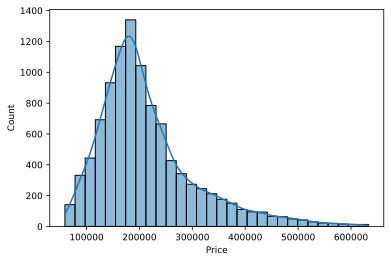

In [4433]:
# Посмотрим, что представляет целевая переменная (все ли адекватно)
sns.histplot(data=train_df, x="Price", bins=30, kde=True)

In [4434]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### 2. Анализ категориальных признаков

In [4435]:
# Определим категориальные признаки
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [4436]:
# Категориальные признаки в строки
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [4437]:
# Cколько квартир по районам
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
207      1
196      1
117      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [4438]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [4439]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [4440]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Предположим, что:
<b>B</b> - маленькие магазины, 
<b>A</b> - торговые центры, гипермаркеты

### 3. Обработаем выбросы

In [4441]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

Выбросы количества комнат не соответствуют площади этих квартир

In [4442]:
# Создадим новый признак и поместим туда где выбросы, и откорректируем выбросы
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[(train_df['Rooms'] == 0), "Rooms"] = train_df['Rooms'].quantile(0.025)
train_df.loc[(train_df['Rooms'] >= 6), "Rooms"] = train_df['Rooms'].quantile(0.975)

In [4443]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2239
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [4444]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [4445]:
train_df.loc[(train_df['HouseFloor'] == 0), 'HouseFloor'] = 1
train_df.loc[(train_df['HouseFloor'] > 95), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [4446]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [4447]:
more_house_floor = train_df.loc[(train_df['Floor'] > train_df['HouseFloor'])].index
train_df.loc[more_house_floor, 'Floor'] = train_df.loc[more_house_floor, 'HouseFloor'].apply(lambda x: random.randint(1,x))

In [4448]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [4449]:
# Откорректируем дома с выбросами
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].median()

In [4450]:
X.loc[train_df['Square'] < 18, 'Square'] = 18
cond = train_df['Square'] > 600
X.loc[cond, 'Square'] = X.loc[cond, 'Square'].apply(lambda x: x/10)
train_df['Square'].describe()


count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [4451]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [4452]:
train_df['KitchenSquare'].quantile(0.025), train_df['KitchenSquare'].quantile(0.975)

cond = ((train_df['KitchenSquare'] > 30) & ~(train_df['LifeSquare'].isna()) & ~(train_df['Square'].isna()))

# Откорректируем сначала значения по относительно общей площади ( отнимем площадь кухни и площадь хоз помещений мин 3 метра например )
square_outliers = train_df.loc[cond, 'KitchenSquare'].index

train_df.loc[square_outliers, 'KitchenSquare'] = train_df.loc[square_outliers, 'Square'] - train_df.loc[square_outliers, 'LifeSquare'] - 3

# И те значения, где например общая площадь была неверна откорректируем по квантилям, дополнительно
cond = ((train_df['KitchenSquare']) > (train_df['KitchenSquare'].quantile(.975)))
train_df.loc[cond, 'KitchenSquare'] = train_df['KitchenSquare'].median()

# Если площадь кухни меньше 4, то корректируем на 4
train_df.loc[(train_df['KitchenSquare'] < 4), 'KitchenSquare'] = 4

In [4453]:
train_df['KitchenSquare'].value_counts()

4.000000     3241
8.000000     1306
6.000000     1274
5.000000     1169
10.000000    1075
9.000000      843
7.000000      609
12.000000     249
11.000000     233
9.998269        1
Name: KitchenSquare, dtype: int64

In [4454]:
train_df.loc[train_df['LifeSquare'] > 800, 'LifeSquare'] = train_df.loc[train_df['LifeSquare'] > 800, 'Square'] - train_df.loc[train_df['Square'] > 800, 'KitchenSquare'] - 3

train_df.loc[(train_df['LifeSquare'] > train_df['Square']), ['LifeSquare', 'Square']]

,LifeSquare,Square
33,74.131261,73.314975
64,87.730225,87.200625
77,39.624493,38.467276
100,82.931595,79.937665
111,32.514021,28.438794
...,...,...
9960,98.152802,96.056784
9962,44.682167,42.029175
9979,41.984322,40.043234
9987,64.602939,62.690057


In [4455]:
# Если значение LifeSquare больше чем Square, то меняем местами, видимо их спутали
incorrect_lifesquare = train_df.loc[(train_df['LifeSquare'] > train_df['Square']), ['Square', 'LifeSquare']].index
train_df.loc[incorrect_lifesquare, ['Square', 'LifeSquare']] = train_df.loc[incorrect_lifesquare, ['LifeSquare', 'Square']].values
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), ['LifeSquare', 'Square']]

,LifeSquare,Square


In [4456]:
# Откорректируем жилую площадь относительно других площадей
cond = ((train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'] + 3) | (train_df['LifeSquare'].isna()))
train_df.loc[cond, ['LifeSquare', 'Square', 'KitchenSquare']]
not_correct_lifesquare = train_df.loc[cond, 'LifeSquare'].index
train_df.loc[not_correct_lifesquare, 'LifeSquare'] = train_df.loc[not_correct_lifesquare,'Square'] - train_df.loc[not_correct_lifesquare, 'KitchenSquare'] - 3

In [4457]:
# Откорректируем минимальное значение жилой площади
train_df.loc[(train_df['LifeSquare'] < train_df['LifeSquare'].quantile(0.125)), 'LifeSquare'] = train_df['LifeSquare'].quantile(0.125)
train_df['LifeSquare'].describe()

count    10000.000000
mean        39.426196
std         20.026906
min         20.859366
25%         24.829058
50%         34.547436
75%         47.845862
max        628.065193
Name: LifeSquare, dtype: float64

### 3. Обработка пропусков

In [4458]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Rooms_outlier       0
dtype: int64

In [4459]:
# Попробуем предсказать Healthcare_1
nan_healthcare = (train_df['Healthcare_1'].isna())


In [4460]:
feature_names = ['Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','LifeSquare','Rooms','Square','Helthcare_2','Shops_1']
Xs = train_df.loc[~nan_healthcare, feature_names]
ys = train_df.loc[~nan_healthcare, ['Healthcare_1']]
X_trains, X_tests, y_trains, y_tests = train_test_split(Xs, ys, test_size = 0.3, random_state=42, shuffle=True)
model = RandomForestRegressor(max_depth=10,random_state=42)
model.fit(X_trains, y_trains.values[:,0])

RandomForestRegressor(max_depth=10, random_state=42)

<AxesSubplot:xlabel='test', ylabel='pred'>

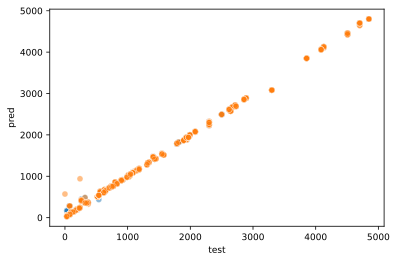

In [4461]:
y_train_pred = model.predict(X_trains)
y_test_pred = model.predict(X_tests)
# Сопоставим реальные и предсказанные
check_test = pd.DataFrame({
   "test": y_tests["Healthcare_1"],
   "pred": y_test_pred.flatten(),
})
check_train = pd.DataFrame({
   "test": y_trains["Healthcare_1"],
   "pred": y_train_pred.flatten(),
})
sns.scatterplot(data=check_train, x="test", y="pred", alpha=.5)
sns.scatterplot(data=check_test, x="test", y="pred", alpha=.5)

In [4462]:
r2_forest_test = r2_score(y_tests["Healthcare_1"], y_test_pred.flatten())
r2_forest_train = r2_score(y_trains["Healthcare_1"], y_train_pred.flatten())
r2_forest_test, r2_forest_train

(0.9984791574170133, 0.9988099959921177)

In [4463]:
train_df.loc[nan_healthcare, 'Healthcare_1'] = model.predict(train_df.loc[nan_healthcare, feature_names])

In [4464]:
# Проверим пропуски, что ничего не забыли
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
Rooms_outlier    0
dtype: int64

In [4465]:
# Создадим класс препроцессинга
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""        
        self.medians = None
        self.kitchen_square_quantile = None
        self.rooms_quantile_min = None
        self.rooms_quantile_max = None
        self.house_floor_mode=None
        self.life_square_quantile = None
        self.feature_names = None
        self.model_healthcare_1 = None
        self.square_quantile_min = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчеты на тренировке
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.rooms_quantile_min = X['Rooms'].quantile(0.025)
        self.rooms_quantile_max = X['Rooms'].quantile(0.975)
        self.house_floor_mode = X['HouseFloor'].mode()[0]
        self.square_quantile_min = X['Square'].quantile(0.025)
        self.life_square_quantile = X['LifeSquare'].quantile(0.125)
        self.feature_names = ['Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','LifeSquare','Rooms','Square','Helthcare_2','Shops_1']
        
    
    def life_square(self, square, kitchen_square):
        return square - kitchen_square - 3

    def square(self, life_square, kitchen_square):
        return life_square + kitchen_square + 3

    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 0), "Rooms"] = 1
        X.loc[(X['Rooms'] >= 6), "Rooms"] = self.medians['Rooms']
        
        # HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[((X['HouseFloor'] == 0) | (X['HouseFloor'] > 95)), 'HouseFloor_outlier'] = 1
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = 1
        X.loc[(X['HouseFloor'] > 95), 'HouseFloor'] = self.medians['HouseFloor']

        # Floor
        more_house_floor = X.loc[(X['Floor'] > X['HouseFloor'])].index
        X.loc[more_house_floor, 'Floor'] = X.loc[more_house_floor, 'HouseFloor'].apply(lambda x: random.randint(1,x))

        # HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        # Square
        X.loc[train_df['Square'] < 18, 'Square'] = 18
        cond = train_df['Square'] > 600
        X.loc[cond, 'Square'] = X.loc[cond, 'Square'].apply(lambda x: x/10)

        # KitchenSquare
        cond = ((X['KitchenSquare'] > 30) & ~(X['LifeSquare'].isna()) & ~(X['Square'].isna()))
        square_outliers = X.loc[cond, 'KitchenSquare'].index
        X.loc[square_outliers, 'KitchenSquare'] = X.loc[square_outliers, 'Square'] - X.loc[square_outliers, 'LifeSquare'] - 3
        cond = ((X['KitchenSquare']) > (self.kitchen_square_quantile))
        X.loc[cond, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['KitchenSquare'] < 4), 'KitchenSquare'] = 4

        # LifeSquare 
        cond = X['LifeSquare'] > 800
        X.loc[X['LifeSquare'] > 800, 'LifeSquare'] = self.life_square(X.loc[cond, 'Square'], X.loc[cond, 'KitchenSquare'])
        
        incorrect_lifesquare = X.loc[(X['LifeSquare'] > X['Square']), ['Square', 'LifeSquare']].index
        X.loc[incorrect_lifesquare, ['Square', 'LifeSquare']] = X.loc[incorrect_lifesquare, ['LifeSquare', 'Square']].values

        cond = ((X['Square'] < self.square(X['LifeSquare'], X['KitchenSquare'])) | (X['LifeSquare'].isna()))
        not_correct_lifesquare = X.loc[cond, 'LifeSquare'].index
        X.loc[not_correct_lifesquare, 'LifeSquare'] = X.loc[not_correct_lifesquare,'Square'] - X.loc[not_correct_lifesquare, 'KitchenSquare'] - 3
        X.loc[(X['LifeSquare'] < self.life_square_quantile), 'LifeSquare'] = self.life_square_quantile

        # Healthcare_1
        nan_healthcare = (X['Healthcare_1'].isna())
        if not self.model_healthcare_1:
            Xs = X.loc[~nan_healthcare, self.feature_names]
            ys = X.loc[~nan_healthcare, ['Healthcare_1']]
            X_trains, X_tests, y_trains, y_tests = train_test_split(Xs, ys, test_size = 0.3, random_state=42, shuffle=True)
            self.model_healthcare_1 = RandomForestRegressor(max_depth=10,random_state=42)
            self.model_healthcare_1.fit(X_trains, y_trains.values[:,0])
            y_train_pred = model.predict(X_trains)
            y_test_pred = model.predict(X_tests)
            r2_forest_test = r2_score(y_tests["Healthcare_1"], y_test_pred.flatten())
            r2_forest_train = r2_score(y_trains["Healthcare_1"], y_train_pred.flatten())
            print(f'Test R2 Healthcare: {r2_forest_test}, Train R2 Healtcare: {r2_forest_train}')

        X.loc[nan_healthcare, 'Healthcare_1'] = self.model_healthcare_1.predict(X.loc[nan_healthcare, self.feature_names])
        
        # Обработаем данные, которые не обработали медианами
        X.fillna(self.medians, inplace=True)

        return X

### 4. Построение новых признаков

In [4466]:
# Переведем в числовые категории
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [4467]:
# Преобразуем номер района в количество измерений в районе в новый признак DistrictSize
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [4468]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014.0,0.075424,...,11,3097,0,656.425945,0,0,1,305018.871089,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,...,30,6207,1,1183.000000,1,0,1,177734.553407,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,...,33,5261,0,240.000000,3,1,1,282078.720850,0,652
3,2352,1,1.0,40.409907,33.409907,4.0,10,22.0,1977.0,0.007122,...,1,264,0,463.743925,0,1,1,168106.007630,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,...,33,8667,2,1205.523851,0,6,1,343995.102962,0,89


In [4469]:
# Признак размера района
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [4470]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [4471]:
# Признак средней цены по району

In [4472]:
# Этажи в категории
def floor_to_cat(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

# Года в категории
def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [4473]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014.0,0.075424,...,656.425945,0,0,1,305018.871089,0,851,1,5,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,...,1183.000000,1,0,1,177734.553407,0,78,0,2,2
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,...,240.000000,3,1,1,282078.720850,0,652,1,3,0
3,2352,1,1.0,40.409907,33.409907,4.0,10,22.0,1977.0,0.007122,...,463.743925,0,1,1,168106.007630,0,652,1,2,3
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,...,1205.523851,0,6,1,343995.102962,0,89,0,2,4


In [4474]:
# Класс для генерации новых признаков
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_social = None
        self.med_price_by_health = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        # District, Rooms
        df = X.copy()
        
        if y is not None:
           df['Price'] = y.values
           self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceByDistrict'})
           self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

           self.med_price_by_social = df.groupby(['Social_1', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceBySocial'})
           self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()

           self.med_price_by_health = df.groupby(['DistrictId', 'Healthcare_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByHealth'})
           self.med_price_by_health_median = self.med_price_by_health['MedPriceByHealth'].median()
            
        ## floor, year
        if y is not None:
           self.floor_max = df['Floor'].max()
           self.house_year_max = df['HouseYear'].max()
           df['Price'] = y.values
           df = self.floor_to_cat(df)
           df = self.year_to_cat(df)
           self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                           rename(columns={'Price':'MedPriceByFloorYear'})
           self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
                
    def transform(self, X):
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(4, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)

        #Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Social_1', 'Social_2'], how='left')
            X.fillna(self.med_price_by_social_median, inplace=True)

        if self.med_price_by_health is not None:
            X = X.merge(self.med_price_by_health, on=['DistrictId', 'Healthcare_1'], how='left')
            X.fillna(self.med_price_by_health_median, inplace=True)
            
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X

### 5. Отбор признаков

In [4475]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat']

### 6. Разбиение на train и test

In [4476]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByFloorYear','MedPriceBySocial','MedPriceByHealth']

target_name = 'Price'

In [4477]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [4478]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [4479]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Test R2 Healthcare: 0.9989262931059834, Train R2 Healtcare: 0.9986283850049138


((6700, 21), (3300, 21), (5000, 21))

In [4480]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [4481]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [4482]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели

In [4483]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=21, max_depth=15, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=21)

Train R2: 0.954,            Test R2:0.728


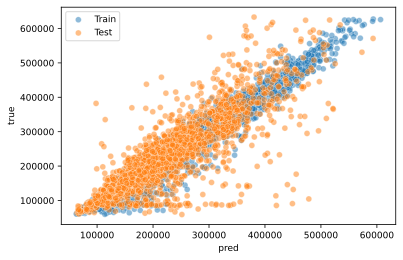

In [4484]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 8. Кросс-валидация

In [4485]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75925829, 0.7228299 , 0.75959853])

In [4486]:
cv_score.mean()

0.7472289053892741

### 9. Важность признаков

In [4487]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.355412
23,MedPriceByHealth,0.296720
22,MedPriceBySocial,0.095525
0,Rooms,0.033743
21,MedPriceByFloorYear,0.029446
2,LifeSquare,0.028737
19,DistrictSize,0.022547
6,HouseYear,0.019676
12,Social_3,0.017702
13,Healthcare_1,0.016386


### 10. Прогнозирование на тестовом датасете

In [4488]:
test_df.shape

(5000, 24)

In [4489]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [4490]:
predictions = rf_model.predict(test_df)
predictions

array([163787.8905061 , 117828.49063607, 209254.22937687, ...,
       147301.63033102, 197944.50564504, 217673.97914697])

In [4491]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163787.890506
1,5925,117828.490636
2,960,209254.229377
3,3848,177124.182081
4,746,168623.980801


In [4492]:
submit.to_csv('rf_submit.csv', index=False)